**Использование LSTM чтобы узнать, позитивное предложение или негативное.**

In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import re
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

Импорт файлов для обучающей выборки

In [33]:
#Импорт файлов
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

texts_true_pd = pd.read_fwf("/content/drive/MyDrive/train_data_true.txt", header = None)
texts_false_pd = pd.read_fwf("/content/drive/MyDrive/train_data_false.txt", header = None)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
texts_true = texts_true_pd
texts_false = texts_false_pd

print(texts_true)

                                                     0
0    Думайте позитивно и верьте в свою способность ...
1    Вы — лучший ответ на проблемы, которые возникл...
2    Если вы смогли в понедельник подняться с посте...
3    Твои утренние мысли в понедельник задают тон в...
4    Живи так чтобы увидеть, как ты становишься сил...
..                                                 ...
117  Правильно поставленная цель уже наполовину дос...
118  Что разум человека может постигнуть и во что о...
119  Стремитесь не к успеху, а к ценностям, которые...
120          Надо любить жизнь больше, чем смысл жизни
121                            Ты выиграешь этот чемпионат, ты справишься!

[122 rows x 1 columns]


In [35]:
texts = pd.concat([texts_true, texts_false], ignore_index=True)
#texts = texts.concat(texts_false)

print(texts)

                                                     0
0    Думайте позитивно и верьте в свою способность ...
1    Вы — лучший ответ на проблемы, которые возникл...
2    Если вы смогли в понедельник подняться с посте...
3    Твои утренние мысли в понедельник задают тон в...
4    Живи так чтобы увидеть, как ты становишься сил...
..                                                 ...
341  Экспериментирование, медленное заражение, внут...
342  Повреждение, необходимая пересадка, тело гниёт...
343  Надрезы ломтями, нулевая видимости, отсутствие...
344                 Вытянутая кожа, костное разрушение
345                         Я провалил сдачу экзамена.

[346 rows x 1 columns]


In [36]:
count_true = len(texts_true)
count_false = len(texts_false)
total_lines = count_true + count_false
print("Количество позитивных предложений в обучающей выборке: ", count_true, "\n", "Количество негативных предложений в обучающей выборке: " ,count_false, "\n", "Всего предложений: ", total_lines)

Количество позитивных предложений в обучающей выборке:  122 
 Количество негативных предложений в обучающей выборке:  224 
 Всего предложений:  346


In [37]:
texts = texts.values.tolist()

Разделение предложений на отдельные слова для составления словаря, и превращения слов в числа

In [38]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
for i in range(total_lines - 1):
  tokenizer.fit_on_texts(texts[i])

dist = list(tokenizer.word_counts.items())

In [39]:
print(dist[:10])
#print(texts[0][:100])
print(texts)

[('думайте', 2), ('позитивно', 4), ('и', 72), ('верьте', 3), ('в', 56), ('свою', 5), ('способность', 1), ('достигать', 2), ('отличных', 1), ('результатов', 1)]
[['Думайте позитивно и верьте в свою способность достигать отличных результатов'], ['Вы — лучший ответ на проблемы, которые возникли в понедельник'], ['Если вы смогли в понедельник подняться с постели, значит вы супер герой'], ['Твои утренние мысли в понедельник задают тон всей твоей неделе'], ['Живи так чтобы увидеть, как ты становишься сильнее и живешь счастливой, полноценной жизнью'], ['Не позволяйте утренним проблемам помешать вам быть успешным'], ['Тяжелые времена часто приводят к величайшим моментам вашей жизни'], ['Продолжайте двигаться Трудности в конце концов создают сильных людей'], ['Независимо через что вы проходите, в конце туннеля есть свет Может показаться, что добраться до него сложно, но вы сможете сделать это'], ['Чем больше вы настроены позитивно и говорите: я хочу иметь хорошую жизнь, тем больше вы строите дл

In [40]:
max_text_len = 10
data = [0]*(total_lines-1)
#print(data)
for i in range(total_lines - 1):
  data[i] = tokenizer.texts_to_sequences(texts[i])

print(data)
new_data = [0]*(total_lines-1)
for i in range (total_lines-1):
  new_data[i] = data[i][0]
data = new_data

#data_pad = [0]*(total_lines-1)
#for i in range(total_lines - 1):
data_pad = pad_sequences(data, maxlen=max_text_len)
print(data_pad)

[[[153, 84, 2, 102, 3, 59, 310, 154, 311, 312]], [[7, 155, 156, 6, 313, 50, 314, 3, 103]], [[21, 7, 315, 3, 103, 157, 14, 316, 60, 7, 317, 318]], [[158, 319, 104, 3, 103, 320, 321, 322, 159, 323]], [[105, 35, 15, 324, 24, 28, 325, 326, 2, 327, 328, 329, 106]], [[1, 107, 330, 331, 332, 36, 41, 333]], [[334, 108, 335, 336, 13, 160, 337, 161, 32]], [[162, 163, 338, 3, 164, 339, 340, 109, 110]], [[341, 342, 5, 7, 343, 3, 164, 344, 37, 165, 51, 345, 5, 346, 85, 347, 348, 33, 7, 166, 45, 8]], [[22, 23, 7, 167, 84, 2, 349, 4, 111, 168, 169, 12, 42, 23, 7, 170, 43, 34, 112, 350]], [[351, 171, 172, 352, 173, 353, 51, 354, 174]], [[86, 175, 355, 356, 13, 161, 32, 357, 13, 358, 359, 360, 3, 361, 362]], [[363, 176, 364, 33, 7, 113, 365, 52, 2, 38, 61, 21, 25, 29, 37, 366]], [[367, 34, 368, 369, 50, 370, 3, 87, 62, 371, 87, 177]], [[178, 53, 372, 114, 373, 3, 34, 179, 374, 375]], [[1, 376, 377, 378, 63, 64, 115, 116, 50, 117, 88, 180, 379, 34]], [[380, 381, 5, 28, 118, 45, 8, 1, 382, 1, 383, 1, 384

Наш словарь:

In [41]:
print( list(tokenizer.word_index.items()) )

[('не', 1), ('и', 2), ('в', 3), ('я', 4), ('что', 5), ('на', 6), ('вы', 7), ('это', 8), ('только', 9), ('все', 10), ('а', 11), ('жизнь', 12), ('к', 13), ('с', 14), ('чтобы', 15), ('то', 16), ('просто', 17), ('меня', 18), ('от', 19), ('мне', 20), ('если', 21), ('чем', 22), ('больше', 23), ('как', 24), ('у', 25), ('за', 26), ('никогда', 27), ('ты', 28), ('вас', 29), ('всегда', 30), ('нет', 31), ('жизни', 32), ('но', 33), ('себя', 34), ('так', 35), ('вам', 36), ('есть', 37), ('без', 38), ('когда', 39), ('мы', 40), ('быть', 41), ('тем', 42), ('для', 43), ('кто', 44), ('сделать', 45), ('своих', 46), ('нужно', 47), ('тебя', 48), ('никому', 49), ('которые', 50), ('может', 51), ('достичь', 52), ('позитивным', 53), ('позитивное', 54), ('того', 55), ('ничего', 56), ('много', 57), ('всё', 58), ('свою', 59), ('значит', 60), ('них', 61), ('мечты', 62), ('твой', 63), ('день', 64), ('себе', 65), ('своей', 66), ('их', 67), ('свои', 68), ('о', 69), ('во', 70), ('лучше', 71), ('никто', 72), ('очень', 73

In [42]:
X = np.array(data_pad)
Y = np.array([[1, 0]]*count_true + [[0, 1]]*count_false)
print(X.shape, Y.shape)

(345, 10) (346, 2)


In [43]:
indeces = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
X = X[indeces]
Y = Y[indeces]

In [44]:
from tensorflow import convert_to_tensor, int64

y_tensor = convert_to_tensor(Y, dtype=int64) 
x_tensor = convert_to_tensor(X, dtype=int64) 

Создаём нейросеть:

In [45]:
model = Sequential()
model.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 10, 128)           128000    
                                                                 
 lstm_5 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 309,122
Trainable params: 309,122
Non-trainable params: 0
_________________________________________________________________


Для сравнения создадим ещё рекуррентную нейросеть

In [46]:
model2 = Sequential()
model2.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
model2.add(SimpleRNN(128, activation='tanh'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 128)           128000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 161,154
Trainable params: 161,154
Non-trainable params: 0
_________________________________________________________________


Обучаем:

In [47]:
history = model.fit(X, Y, batch_size=32, epochs=50)

Epoch 1/50
11/11 [==============================] - 7s 36ms/step - loss: 0.6861 - accuracy: 0.6580
Epoch 2/50
11/11 [==============================] - 0s 41ms/step - loss: 0.6679 - accuracy: 0.6464
Epoch 3/50
11/11 [==============================] - 0s 34ms/step - loss: 0.6452 - accuracy: 0.6464
Epoch 4/50
11/11 [==============================] - 0s 37ms/step - loss: 0.6095 - accuracy: 0.6464
Epoch 5/50
11/11 [==============================] - 0s 38ms/step - loss: 0.5586 - accuracy: 0.6464
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 0.5059 - accuracy: 0.6464
Epoch 7/50
11/11 [==============================] - 0s 39ms/step - loss: 0.4726 - accuracy: 0.6522
Epoch 8/50
11/11 [==============================] - 0s 37ms/step - loss: 0.4515 - accuracy: 0.7594
Epoch 9/50
11/11 [==============================] - 0s 44ms/step - loss: 0.4336 - accuracy: 0.8435
Epoch 10/50
11/11 [==============================] - 0s 40ms/step - loss: 0.4161 - accuracy: 0.8551
Epoch 11/

In [48]:
history2 = model2.fit(X, Y, batch_size=32, epochs=50)

Epoch 1/50
11/11 [==============================] - 3s 19ms/step - loss: 0.6319 - accuracy: 0.7043
Epoch 2/50
11/11 [==============================] - 0s 17ms/step - loss: 0.5298 - accuracy: 0.7391
Epoch 3/50
11/11 [==============================] - 0s 15ms/step - loss: 0.4702 - accuracy: 0.7681
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.4350 - accuracy: 0.8029
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3995 - accuracy: 0.8609
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3662 - accuracy: 0.8812
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3371 - accuracy: 0.8870
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3086 - accuracy: 0.8841
Epoch 9/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2810 - accuracy: 0.8928
Epoch 10/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2614 - accuracy: 0.9072
Epoch 11/

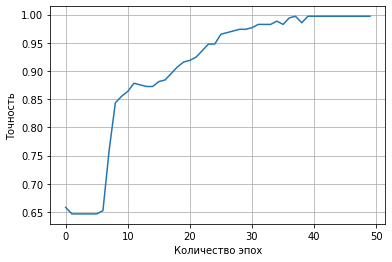

In [49]:
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.show()

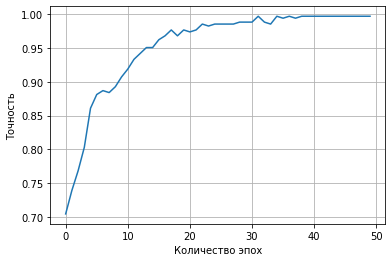

In [50]:
plt.plot(history2.history['accuracy'])
plt.grid(True)
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.show()

In [51]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

Функция превращающая числа из словаря обратно в слово

In [52]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

Проверим LSTM на деле:

In [64]:
t = "Улыбок тебе, дед Макар".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=max_text_len)
#print( sequence_to_text(data[0]) )

In [66]:
res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')
if (np.argmax(res) == 0):
  print("Предложение позитивное!")
else:
  print("Предложение негативная!")

1/1 [==============================] - 0s 25ms/step
[[0.81515473 0.18484525]]
0
Предложение позитивное!


In [67]:
t = "Я не сдал экзамен - какая жалость!".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=max_text_len)
print( sequence_to_text(data[0]) )

['я', 'не', 'сдал']


In [69]:
res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')
if (np.argmax(res) == 0):
  print("Предложение позитивное!")
else:
  print("Предложение негативное!")

1/1 [==============================] - 0s 36ms/step
[[0.00734808 0.992652  ]]
1
Предложение негативное!


Теперь проверим RNN:

In [70]:
t = "Улыбок тебе, дед Макар".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=max_text_len)

In [71]:
res = model2.predict(data_pad)
print(res, np.argmax(res), sep='\n')
if (np.argmax(res) == 0):
  print("Предложение позитивное!")
else:
  print("Предложение негативная!")

1/1 [==============================] - 0s 171ms/step
[[0.8630532 0.1369468]]
0
Предложение позитивное!


In [72]:
t = "Я не сдал экзамен - какая жалость!".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=max_text_len)

In [73]:
res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')
if (np.argmax(res) == 0):
  print("Предложение позитивное!")
else:
  print("Предложение негативное!")

1/1 [==============================] - 0s 27ms/step
[[0.00734808 0.992652  ]]
1
Предложение негативное!
